# Simulation of soft computing course's project
#### Author: Mahdi Tanbakuchi             


<b> First required libraries are imported to the workspace </b>

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from itertools import permutations

<i> Now lets define the model to generate our data which can be later used for evaluating the idea proposed in the abstract</i><br>
Below the Fr represents the acceptable frequnecies for the normal case while the Fw is representetive for the abnormal case. scale is used to generate samples from the frequency ranges randomly

In [2]:
Fr = np.linspace(0,7,30)
Fr = np.concatenate((Fr,np.linspace(11,15,30)))
Fw = np.linspace(8,10,30)
Fr = np.random.permutation(Fr)
Fw = np.random.permutation(Fw)
scale = np.linspace(1,100,100)
scale = np.random.permutation(scale)

Now lets define experimental settings:


In [3]:
fs = 32       # in hertz    
duration=8   # in seconds
ch = 8       # Number of channels

Now that all the ingredients of the generator is made ready it is time to define the generator itself: <br>
The generator works as follows:
1. uses cosine function with the given frequency 
2. uses the wegith to superpose all the given frequencies 
<br>

The sampling frequency should also be given to the code (fs=256 hz by default)

In [4]:
def datagen(freq,coef,fs=32,duration=8):    
    t = np.arange(0,duration,1/fs)
    y = np.zeros(t.shape)
    if(np.linalg.norm(coef)!=1):
        coefnorm = coef/np.linalg.norm(coef)
    for i,j in zip(freq,coefnorm):
        y+=j*np.cos(2*np.pi*i*t)
    return y
        
    

Now parameter selection must be done in order to simulate the data for evaluation.<br> 
Here the following assumtions are made:
1. Only 5 components for each signal are used no more and no less
2. The two scenarios are assumed to be destinguishable in frequency bands 
3. The whole dataset size is set to 10000
4. the class in the training data set is imbalanced as is the case in real scenarios (80% normal and 20% abnormal case)

In [5]:
N = 5 
datasetsize = 10000
clr = 0.2
t = np.arange(0,duration,1/fs)
Frd = permutations(Fr,N)
Fwd = permutations(Fw,N)
scale1=permutations(scale,N)
scale = np.random.permutation(scale)
scale2=permutations(scale,N)
posdatasize = np.int32(datasetsize*(1-clr))
negdatasize = np.int32(datasetsize*clr)
posdata = []
negdata = []
for i in range(posdatasize):
    posdata.append(datagen(next(Frd),next(scale1)))
for i in range(negdatasize):
    negdata.append(datagen(next(Fwd),next(scale2)))


Let's see one of our subject samples (one channel of a subject) 

Text(0.5, 1.0, 'Abnormal case')

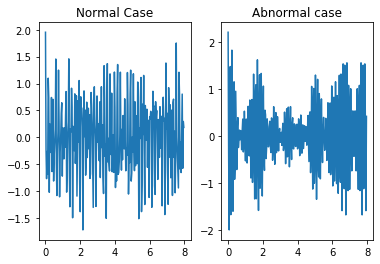

In [6]:
a1 = plt.subplot(121)
plt.plot(t,posdata[0])
a1.set_title("Normal Case")
a2 = plt.subplot(122)
plt.plot(t,negdata[0])
a2.set_title("Abnormal case")


In order to simulate wake labelling procedure as that happens in the real scenarios, we use the data produced in the previous stpes and sample from each ch times to obtain a ch-channel EEG signal sample data of duration length. Samples having at least one data from negdata are considered as abnormal case in the new training dataset. <br>
Below the normal EEG data is produced.

In [58]:
weakpositer = permutations(posdata,ch) 
posdataweak = np.zeros((posdatasize,ch,*t.shape))
classid = np.zeros((posdatasize))
for i in range(posdatasize):
    posdataweak[i]=np.array(next(weakpositer))

Below the abnormal EEG data is produced. First we decide how many channels are consistent with abnormal conditions afterwards we decide on which channel the abnormal EEG sample signal is to be appeared.

In [59]:
nums = random.choices(range(1,4),k=negdatasize)
positions = [random.sample(range(0,8),k=i) for i in nums]
posdata2 = iter(np.random.permutation(posdata))
negdata2 = iter(np.random.permutation(negdata))
negdataweak=[]
negdata3=np.zeros((negdatasize,ch,*t.shape))
classid = np.concatenate((classid,np.ones((negdatasize))))
index = 0
w0 = 1/posdatasize
w1 = 1/negdatasize
for pos in positions:
    for i in range(8):
        if(i in pos):
            try:
                negdata3[index,i,:] = next(negdata2)
            except StopIteration:
                negdata2 = iter(np.random.permutation(negdata))
                negdata3[index,i,:] = next(negdata2)
        else:
            try:
                negdata3[index,i,:] = next(posdata2)
            except StopIteration:
                posdata2 = iter(np.random.permutation(posdata))
                negdata3[index,i,:] = next(posdata2)
    index+=1
            
negdataweak = negdata3
datasetweak = np.concatenate((posdataweak,negdataweak))
datasetweak = np.expand_dims(datasetweak,-1)

Now we have produced the synthetic data conforming with the weak labels as that mentioned in the article; its time to train the proposed deep FCN with the procedure outlined in the paper. 

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [51]:
dummy = np.expand_dims(posdataweak,-1)
input_shape = dummy.shape[1:]

model = keras.Sequential(
    [
        # Feature extraction block
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.BatchNormalization(),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.BatchNormalization(),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.Conv2D(32, kernel_size=(1,3), activation="relu"),
        layers.BatchNormalization(),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        # Classification Block
        layers.Conv2D(2, kernel_size=(1,3), activation="relu"),
        layers.AveragePooling2D(pool_size=(1,4),strides=(1,3)),
        layers.MaxPooling2D(pool_size=(ch,1)),
        layers.Flatten(),
        layers.Softmax()
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 8, 254, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 252, 32)        3104      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 250, 32)        3104      
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 250, 32)        128       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 8, 83, 32)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 81, 32)         3104      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 79, 32)        

<b>Now that the model is created it should be trained using the training data</b>

In [62]:
batch_size = 300
epochs = 15
num_classes = 2
ylabel = keras.utils.to_categorical(classid, num_classes)
X_train,X_test,Y_train,Y_test = train_test_split(datasetweak,ylabel,test_size = 0.2 , random_state=2)
sgd = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9, nesterov=True, name="SGD"
)
model.compile(loss="binary_crossentropy",optimizer=sgd,metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

class_weight = {0: w0, 1: w1}
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,callbacks=[callback],class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 7200 samples, validate on 800 samples
Epoch 1/15
1800/7200 [======>.......................] - ETA: 1:09 - loss: 1.7310e-04 - accuracy: 0.6640

KeyboardInterrupt: 

In [128]:
# posdataweak = np.array(posdataweak)
# negdataweakk = np.array(negdataweak)
# np.all(negdataweak[1]==negdataweak[10])
# np.all(posdataweak[2]==posdataweak[2])
# negdataweak
# posdataweak
input_shape

(8, 256)

## Test section 

In [122]:
class myclass:
    def __init__(self,a=10,b=5):
        self.a= a
        self.b = b
    def __call__(self):
        return self.a+self.b
        
a = myclass(2)
a()

7

In [79]:
a = np.ones((1,3))
b = np.ones((3,))*2
c = np.ones((3,))*3
d = [a,b,c]
dd = np.array(d)
a
np.all()

array([[1., 1., 1.]])

In [64]:
a=np.array([[1,2],[2,3],[3,4]])
print(a)
print(a.shape)
a=np.expand_dims(a,-1)
print(a)
print(a.shape)
# input_shape[::-1]
# np.expand_dims()
dummy.shape
# yy = keras.utils.to_categorical([1,0,1,1,0,0],num_classes=2)
# yy
Y_train


[[1 2]
 [2 3]
 [3 4]]
(3, 2)
[[[1]
  [2]]

 [[2]
  [3]]

 [[3]
  [4]]]
(3, 2, 1)


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)